## Imports and Functions definition

Import includes fastai functions, libraries called in fastai packages and for evaluation metric, 3 functions from Ben Hamner's github was taken.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from IPython.display import display

def head_file(path):
    with open(path) as f:
        for _ in range(5):
            print(f.readline())

def split_val(a, n):
    return a[:n].copy(), a[n:].copy()

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

C:\Users\ohjia\anaconda3\envs\fastai-cpu\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\ohjia\anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat
def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings
def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))
    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)
    numerator = 0.0
    denominator = 0.0
    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items
    return (1.0 - numerator / denominator)

def print_score(m):
    res = [
        #"train_Rsq: ", m.score(train_X, train_y), "\n",
        #"validation_Rsq: ", m.score(valid_X, valid_y), "\n",
        "train_Kappa", quadratic_weighted_kappa(train_y.astype(str), m.predict(train_X).astype(str)), "\n",
        "validation_Kappa", quadratic_weighted_kappa(valid_y.astype(str), m.predict(valid_X).astype(str))
    ]
    if hasattr(m, "oob_score_"):
        res.append("OOB_Score: ")
        res.append(m.oob_score_)
    for i in range(0, len(res)):
        if res[i] == "\n":
            print("\n")
        else:
            print(res[i])

## (Skip when re-run) Preliminary check of datasets

In [3]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 4CA3-334F

 Directory of C:\Users\ohjia\jupyter\dsbowl

16/06/2020  02:15 PM    <DIR>          .
16/06/2020  02:15 PM    <DIR>          ..
16/06/2020  01:52 PM    <DIR>          .ipynb_checkpoints
16/06/2020  02:15 PM            28,003 Actual.ipynb
07/06/2020  01:59 PM    <SYMLINKD>     fastai [..\libraries\fastai]
07/06/2020  01:07 AM       398,327,795 test.csv
16/06/2020  02:08 PM    <DIR>          tmp
07/06/2020  01:01 AM     3,878,373,417 train.csv
07/06/2020  12:50 AM         1,124,229 train_labels.csv
14/06/2020  02:12 PM            72,893 Untitled.ipynb
               5 File(s)  4,277,926,337 bytes
               5 Dir(s)  171,395,940,352 bytes free


In [4]:
head_file("train.csv")

event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world

27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE

27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK

77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK

b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""total_duration"":6758,""event_count"":2,""game_time"":53,""event_code"":3010}",0001e90f,2,3010,53,Sand

In [5]:
head_file("train_labels.csv")

game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group

6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1,3

77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0,0

901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1,3

9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2



## (Skip when re-run) Reading train and test sets

Read and look at dataset columns 

In [4]:
%time left = pd.read_csv("train.csv")
%time right = pd.read_csv("train_labels.csv")
%time test = pd.read_csv("test.csv")

Wall time: 43.3 s
Wall time: 156 ms
Wall time: 4.86 s


In [8]:
left.nunique()

event_id                384
game_session         303319
timestamp          10777308
event_data         10893749
installation_id       17000
event_count            3368
event_code               42
game_time            834048
title                    44
type                      4
world                     4
dtype: int64

In [5]:
right.nunique()

game_session       17690
installation_id     3614
title                  5
num_correct            2
num_incorrect         46
accuracy              30
accuracy_group         4
dtype: int64

In [6]:
print(left.shape, right.shape, test.shape)

(11341042, 11) (17690, 7) (1156414, 11)


Merge the independent variables with the dependent

In [10]:
%time train = pd.merge(left, right, on=["installation_id", "game_session"])
# inner is same as right merge for this case I think

Wall time: 26 s


In [11]:
train.shape

(865447, 16)

In [12]:
train.accuracy_group.isnull().any()

False

Save temporary dataframes

In [13]:
os.makedirs("tmp", exist_ok = True)
train.to_feather("tmp/trn")
test.to_feather("tmp/tes")

## (Skip when re-run) Initial Processing

In [14]:
train = pd.read_feather("tmp/trn")
test = pd.read_feather("tmp/tes")

Filter the training data columns which are not included in Test Set

In [15]:
test.columns

(865447, 16)

In [20]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title_x',
       'type', 'world', 'title_y', 'num_correct', 'num_incorrect', 'accuracy',
       'accuracy_group'],
      dtype='object')

In [23]:
train.title_x
# title_x and title_y are the same

0         Mushroom Sorter (Assessment)
1         Mushroom Sorter (Assessment)
2         Mushroom Sorter (Assessment)
3         Mushroom Sorter (Assessment)
4         Mushroom Sorter (Assessment)
                      ...             
865442    Cauldron Filler (Assessment)
865443    Cauldron Filler (Assessment)
865444    Cauldron Filler (Assessment)
865445    Cauldron Filler (Assessment)
865446    Cauldron Filler (Assessment)
Name: title_y, Length: 865447, dtype: object

In [24]:
train.drop(["title_y", "num_correct", "num_incorrect", "accuracy"], axis=1, inplace=True)

In [26]:
train.rename(columns={"title_x":"title"}, inplace=True)

In [27]:
train.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world', 'accuracy_group'],
      dtype='object')

In [28]:
train.to_feather("tmp/trn2")

## Processing

In [5]:
train = pd.read_feather("tmp/trn2")

##### Dataset information

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865447 entries, 0 to 865446
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_id         865447 non-null  object
 1   game_session     865447 non-null  object
 2   timestamp        865447 non-null  object
 3   event_data       865447 non-null  object
 4   installation_id  865447 non-null  object
 5   event_count      865447 non-null  int64 
 6   event_code       865447 non-null  int64 
 7   game_time        865447 non-null  int64 
 8   title            865447 non-null  object
 9   type             865447 non-null  object
 10  world            865447 non-null  object
 11  accuracy_group   865447 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 79.2+ MB


In [6]:
train.describe()

,event_count,event_code,game_time,accuracy_group
count,865447.000000,865447.000000,8.654470e+05,865447.000000
mean,37.914465,3593.477654,6.218941e+04,1.533335
std,50.163982,655.223229,9.601085e+05,1.240931
min,1.000000,2000.000000,0.000000e+00,0.000000
25%,13.000000,3110.000000,1.008300e+04,0.000000
50%,26.000000,4025.000000,2.284900e+04,1.000000
75%,46.000000,4035.000000,4.479300e+04,3.000000
max,1274.000000,4110.000000,3.069102e+08,3.000000


In [8]:
train.event_code.nunique()

22

### (1) Split JSON column

##### Split event_data

"event_data" column is in json format containing extra information  
this code separates each key-value pair into part of a column

In [6]:
tmp0 = pd.json_normalize(train.event_data.apply(json.loads))

Drop duplicated columns

In [ ]:
tmp0.drop(["event_code", "event_count", "game_time"],axis=1, inplace=True)

Merge the newly created columns and the original dataset

In [8]:
tmp1 = pd.concat([tmp0, train], axis=1)

In [9]:
tmp1.drop("event_data", axis=1, inplace=True)

##### (Skip) Alternative: Drop the column

In [7]:
train.drop("event_data", axis=1, inplace=True)

##### (Skip) ERROR with splitting event_data

In [139]:
train_cat = train.iloc[:,[0,4,5,6,14,15,16,17,20,23,24,25,27,28,30,31,34,36,37,39,40,41,42,43,45]].copy()

In [140]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865447 entries, 0 to 865446
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   version         17690 non-null   object
 1   description     239152 non-null  object
 2   identifier      239152 non-null  object
 3   media_type      239152 non-null  object
 4   stumps          46121 non-null   object
 5   source          309519 non-null  object
 6   destination     77831 non-null   object
 7   correct         133772 non-null  object
 8   exit_type       2925 non-null    object
 9   caterpillar     67293 non-null   object
 10  hats            52204 non-null   object
 11  caterpillars    78662 non-null   object
 12  hats_placed     8363 non-null    object
 13  buckets         58549 non-null   object
 14  mode            14430 non-null   object
 15  prompt          20120 non-null   object
 16  buckets_placed  57081 non-null   object
 17  crystals        85339 non-nul

In [142]:
train_num = train.iloc[:,[1,2,3,7,8,9,10,11,12,13,18,19,21,22,26,29,32,33,35,38,44]].copy()

In [143]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865447 entries, 0 to 865446
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   event_count               865447 non-null  int64  
 1   game_time                 865447 non-null  int64  
 2   event_code                865447 non-null  int64  
 3   total_duration            120390 non-null  float64
 4   duration                  314966 non-null  float64
 5   height                    78305 non-null   float64
 6   coordinates.x             504202 non-null  float64
 7   coordinates.y             504202 non-null  float64
 8   coordinates.stage_width   504202 non-null  float64
 9   coordinates.stage_height  504202 non-null  float64
 10  misses                    17419 non-null   float64
 11  session_duration          11686 non-null   float64
 12  stage_number              7860 non-null    float64
 13  hat                       51344 non-null   f

In [168]:
tmp = get_sample(train_cat, 10)
tmp.stumps

52977           NaN
189678          NaN
296823          NaN
404589          NaN
412253          NaN
532516          NaN
567189          NaN
604304          NaN
715121    [4, 5, 3]
825388          NaN
Name: stumps, dtype: object

In [151]:
train_cat.astype("category", copy=False).dtypes

TypeError: unhashable type: 'list'

Error identified: column containing list as their objects  
Proposed solution: expand each element of the list to a few rows >> may result in explosion of number of rows

##### Solution

Problem: There are columns which has lists as their elements  
Solution: Replicate the rows for all the individual elements in the list (using explode)

Columns with  
list objects >> stumps, hats, caterpillars, hats_placed, buckets, buckets_placed, pillars, chests  
json >> crystals, left, right

In [10]:
%time tmp1 = tmp1.explode("stumps")
%time tmp1 = tmp1.explode("hats")
%time tmp1 = tmp3.explode("caterpillars")
%time tmp1 = tmp1.explode("hats_placed")
%time tmp1 = tmp1.explode("buckets")
%time tmp1 = tmp1.explode("buckets_placed")
%time tmp1 = tmp1.explode("pillars")
%time tmp9 = tmp1.explode("chests")

Wall time: 10.2 s
Wall time: 11.7 s
Wall time: 14.9 s
Wall time: 16.7 s
Wall time: 17.3 s
Wall time: 18.4 s
Wall time: 20.3 s
Wall time: 20.8 s


Problem: cannot split the json columns because they have float as objects

##### (Skip) ERROR with splitting numeric json

In [24]:
tmp8 = pd.io.json.json_normalize(tmp7.crystals.apply(json.loads))
tmp9 = pd.io.json.json_normalize(tmp8.left.apply(json.loads))
tmp10 = pd.io.json.json_normalize(tmp9.right.apply(json.loads))

TypeError: the JSON object must be str, bytes or bytearray, not 'float'

In [21]:
tt = get_sample(tmp7, 20)
tt.crystals

50534                                NaN
70925                                NaN
166287                               NaN
241347                               NaN
286157                               NaN
304382                               NaN
321196    [{'id': 'gem07', 'weight': 6}]
472394                               NaN
541525                               NaN
588937                               NaN
597285                               NaN
599448                               NaN
614016                               NaN
622451                               NaN
704468                               NaN
732465                               NaN
779274                               NaN
780493                               NaN
804624                               NaN
833310                                []
Name: crystals, dtype: object

In [10]:
tmp7.shape

(1943261, 46)

In [15]:
tmp7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1943261 entries, 0 to 865446
Data columns (total 43 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   version                   category
 1   event_count               int64   
 2   game_time                 int64   
 3   event_code                int64   
 4   description               category
 5   identifier                category
 6   media_type                category
 7   total_duration            float64 
 8   duration                  float64 
 9   height                    float64 
 10  coordinates.x             float64 
 11  coordinates.y             float64 
 12  coordinates.stage_width   float64 
 13  coordinates.stage_height  float64 
 14  stumps                    category
 15  source                    category
 16  destination               category
 17  correct                   category
 18  misses                    float64 
 19  session_duration          float64 
 20  exi

##### Alternative: Drop json columns 

Some other columns have insignificant data in JSON format which are hard to process

In [11]:
tmp9.drop(["crystals", "left", "right"], inplace=True, axis = 1)

In [12]:
train = tmp9.copy()

### (2) Columns Processing

Timestamp is pretty much insignificant and cannot be extrapolated for test set

In [13]:
train.drop("timestamp", axis=1, inplace=True)

### (3) FastAI Preprocessing

Installation IDs are randomly generated and there are no overlapping IDs between training and test set

In [15]:
train.drop("installation_id", axis=1, inplace=True)

Convert Type: Object > Category

In [16]:
train_cats(train)

In [17]:
## event code is categorical, but numeric >> try to make it object type
train.event_code = train.event_code.astype("category", copy=False)
train.accuracy_group = train.accuracy_group.astype("category", copy=False)

In [18]:
train.reset_index(inplace=True)
train.to_feather("tmp/trn3")

In [3]:
train = pd.read_feather("tmp/trn3")

Numericalise the categorical values, deal with missing values and one-hot encoding.  
Finally, split into dependent and independent variables

In [4]:
full_X, full_y, nas = proc_df(train, "accuracy_group", max_n_cat = 7)

### (4) Split Validation Set

80/20 split

In [5]:
train_size = int((len(full_X)*0.8) // 1)

In [6]:
train_X, valid_X = split_val(full_X, train_size)
train_y, valid_y = split_val(full_y, train_size)

## Trial Run

In [7]:
set_rf_samples(200000)

In [8]:
# histogram problem: we temporarily add 1 to label
train_y = train_y + 1
valid_y = valid_y + 1

In [13]:
m = RandomForestClassifier(n_jobs=-1, oob_score=False,
                          n_estimators = 40, min_samples_leaf = 5, max_features = 0.5)
%time m.fit(train_X, train_y)

Wall time: 3min 14s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Save model >> for re-run

In [15]:
print_score(m)

train_Kappa
0.9553066463923476


validation_Kappa
0.578021799710181


In [14]:
import joblib

joblib.dump(m, "tmp/mod1.pkl")

['tmp/mod1.pkl']

In [11]:
import joblib

m = joblib.load("tmp/mod1.pkl")

## Interpretations

In [12]:
# these are backups in case I want to restore the dataset I modified to an earlier state

sto0 = train_X
sto1 = train_y
sto2 = valid_X
sto3 = valid_y
sto4 = full_X
sto5 = full_y

#### (Skip when re-run) Feature Importance

In [13]:
fi = rf_feat_importance(m, train_X)

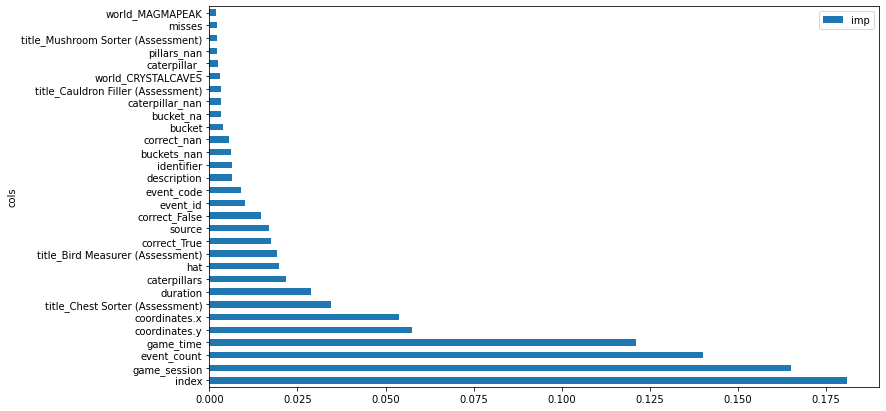

In [14]:
fi[:30].plot("cols", "imp", "barh", figsize = (12, 7))

In [15]:
sig_cols = fi[fi.imp>0.010].cols

In [16]:
sig_cols

0                                 index
26                         game_session
27                          event_count
29                            game_time
7                         coordinates.y
6                         coordinates.x
122     title_Chest Sorter (Assessment)
4                              duration
15                         caterpillars
14                                  hat
119    title_Bird Measurer (Assessment)
67                         correct_True
10                               source
66                        correct_False
25                             event_id
Name: cols, dtype: object

game_session - Randomly generated unique identifier grouping events within a single game or video play session.  
installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.  
event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.  
timestamp - Client-generated datetime  
event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.  
event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.  
game_time - Time in milliseconds since the start of the game session. Extracted from event_data.  
title - Title of the game or video.  

In [17]:
train2_X = train_X[sig_cols].copy()
valid2_X = valid_X[sig_cols].copy()
full2_X = full_X[sig_cols].copy()

In [18]:
train2_X.head()

,index,game_session,event_count,game_time,coordinates.y,coordinates.x,title_Chest Sorter (Assessment),duration,caterpillars,hat,title_Bird Measurer (Assessment),correct_True,source,correct_False,event_id
0,0,9875,1,0,436.0,521.0,0,1000.0,0,0.0,0,0,0,0,23
1,1,9875,2,37,436.0,521.0,0,1000.0,0,0.0,0,0,0,0,86
2,2,9875,3,37,436.0,521.0,0,1000.0,0,0.0,0,0,0,0,66
3,3,9875,4,3901,436.0,521.0,0,3864.0,0,0.0,0,0,0,0,67
4,4,9875,5,3901,436.0,521.0,0,1000.0,0,0.0,0,0,0,0,66


In [19]:
train_X = train2_X.copy()
valid_X = valid2_X.copy()
full_X = full2_X.copy()

In [20]:
m = RandomForestClassifier(n_jobs=-1, oob_score=False,
                          n_estimators = 40, min_samples_leaf = 5, max_features = 0.5)
%time m.fit(train_X, train_y)

Wall time: 1min 18s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [21]:
print_score(m)

train_Kappa
0.9401132129222873


validation_Kappa
0.5825745801276405


fi.imp:
* all >> 0.5699454817097576
* 0.010 >> 0.576720335751661
* 0.02 >> 0.4123768551571235  
* 0.025 >> 0.4188415868130472
* 0.05 >> 0.408959788819087

#### (Skip when re-run) Dendrogram

In [22]:
from scipy.cluster import hierarchy as hc
from matplotlib import pyplot
%pylab

def dendro(df):
	corr = np.round( scipy.stats.spearmanr(df).correlation , 4 )
	corr_condensed = hc.distance.squareform( 1-corr )
	z = hc.linkage(corr_condensed, method = "average" )
	fig = plt.figure( figsize(16,10) )
	dendrogram = hc.dendrogram( z, labels = df.columns, orientation="left", leaf_font_size=16 )
plt.show()

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


C:\Users\ohjia\anaconda3\envs\fastai-cpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'random', 'interactive', 'histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\ohjia\anaconda3\envs\fastai-cpu\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\ohjia\anaconda3\envs\fastai-cpu\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\ohjia\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\ohjia\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\ohjia\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\ohjia\AppData\Roaming\Python\Python36\site-packages\matplotlib\backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplot

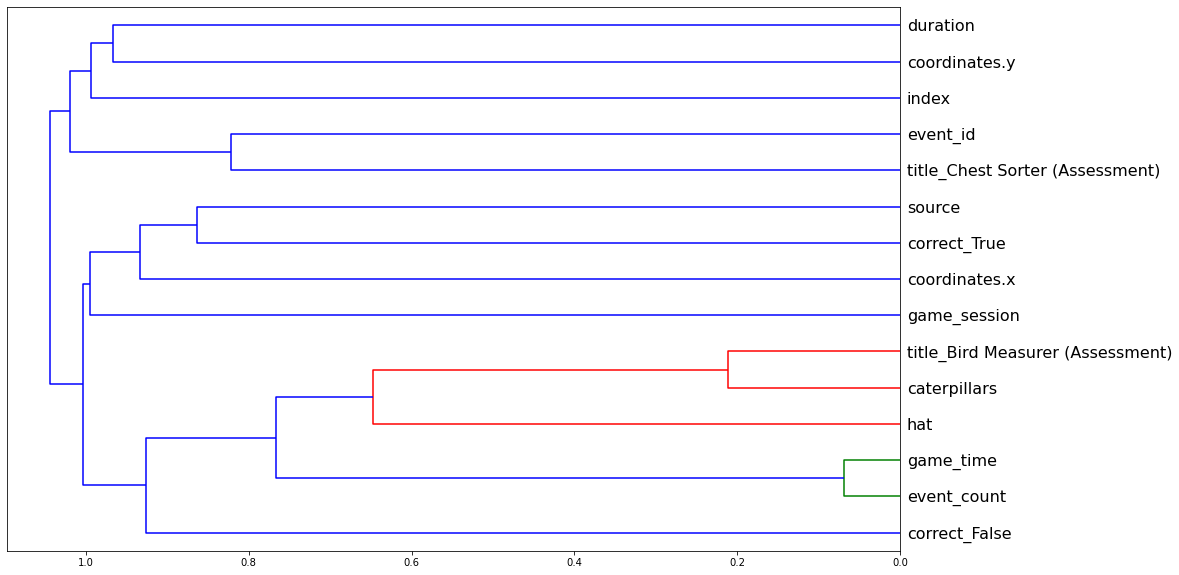

In [23]:
dendro(train_X)

In [24]:
def get_oob(tmp_X):
    m = RandomForestRegressor(n_estimators=50, min_samples_leaf=5, max_features=0.5,
                              n_jobs=-1, oob_score=True)
    m.fit(tmp_X, train_y)
    return m.oob_score_

In [76]:
# baseline
get_oob(train_X)

0.8390650107068918

In [77]:
for c in ["game_time", "event_count", "title_Bird Measurer (Assessment)", "caterpillars"]:
    print(c, get_oob(train_X.drop(c, axis=1)))

game_time 0.8311020048304971
event_count 0.8347273465991839
title_Bird Measurer (Assessment) 0.8285117543960591
caterpillars 0.8462713113952098


In [25]:
to_drop = ["index", "caterpillars"]

train_X.drop(to_drop, axis=1, inplace=True)
valid_X.drop(to_drop, axis=1, inplace=True)
full_X.drop(to_drop, axis=1, inplace=True)

In [32]:
train_X.columns

Index(['game_session', 'event_count', 'game_time', 'coordinates.y',
       'coordinates.x', 'title_Chest Sorter (Assessment)', 'duration', 'hat',
       'title_Bird Measurer (Assessment)', 'correct_True', 'source',
       'correct_False', 'event_id'],
      dtype='object')

#### Test the new features (kept columns)

In [33]:
np.save("tmp/keep_cols.npy", np.array(train_X.columns))

In [34]:
keep_cols = np.load("tmp/keep_cols.npy", allow_pickle = True)

In [35]:
valid_X = sto2[keep_cols].copy()
train_X = sto0[keep_cols].copy()
full_X = sto4[keep_cols].copy()

In [84]:
reset_rf_samples()

In [36]:
m = RandomForestClassifier(n_jobs=-1, oob_score=False,
                          n_estimators = 100, min_samples_leaf = 5, max_features = 0.5)
%time m.fit(train_X, train_y)

Wall time: 3min 1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [37]:
print_score(m)

TypeError: 'numpy.int32' object is not iterable

In [40]:
joblib.dump(m, "tmp/mod2.pkl")

['tmp/mod2.pkl']

## Checkpoint

#### (Skip when re-run) Saving

In [41]:
valid_X.reset_index(inplace=True)

train_X.to_feather("tmp/trainX")
valid_X.to_feather("tmp/validX")
full_X.to_feather("tmp/fullX")

In [42]:
np.save("tmp/trainy.npy", train_y)
np.save("tmp/validy.npy", valid_y)
np.save("tmp/fully.npy", full_y)

#### Loading (contains everything needed for next sections)

Here are all the objects needed for the next sections

In [44]:
# this is for the apply_cats reference in Test Set Processing

t0 = pd.read_feather("tmp/trn2")
t1 = pd.json_normalize(t0.event_data.apply(json.loads))
t1.drop(["event_code", "event_count", "game_time"],axis=1, inplace=True)
t2 = pd.concat([t0, t1], axis=1)
t2.drop("event_data", axis=1, inplace=True)
%time t2 = t2.explode("stumps")
%time t2 = t2.explode("hats")
%time t2 = t2.explode("caterpillars")
%time t2 = t2.explode("hats_placed")
%time t2 = t2.explode("buckets")
%time t2 = t2.explode("buckets_placed")
%time t2 = t2.explode("pillars")
%time t10 = t2.explode("chests")
t10.drop(["crystals", "left", "right"], inplace=True, axis = 1)
t10.drop(["installation_id", "timestamp"], axis=1, inplace=True)
train_cats(t10)

# for the Test Set processing proc_df reference dictionary
t10.event_code = t10.event_code.astype("category", copy=False)
t10.accuracy_group = t10.accuracy_group.astype("category", copy=False)
_, _, nas = proc_df(t10, "accuracy_group", max_n_cat = 7)

Wall time: 11 s
Wall time: 11.5 s
Wall time: 13.6 s
Wall time: 15.3 s
Wall time: 15.8 s
Wall time: 17.6 s
Wall time: 20.6 s
Wall time: 20.5 s


In [71]:
train_X = pd.read_feather("tmp/trainX")
valid_X = pd.read_feather("tmp/validX")
valid_X.drop("index", axis=1, inplace=True)
full_X = pd.read_feather("tmp/fullX")

train_y = np.load("tmp/trainy.npy", allow_pickle=True)
valid_y = np.load("tmp/validy.npy", allow_pickle=True)
full_y = np.load("tmp/fully.npy", allow_pickle=True)

In [3]:
keep_cols = np.load("tmp/keep_cols.npy", allow_pickle = True)

In [47]:
# Test Set
test = pd.read_feather("tmp/tes")

## (Skip when re-run) Hyperparameters tuning

#### (Skip when re-run) Testing space

In [44]:
?RandomForestClassifier

In [45]:
para_space = {"max_features" : [0.5, "sqrt", "log2"],
              "min_samples_leaf" : [1, 3, 5, 10]}

In [53]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(m, para_space,
                           cv = 3, n_jobs = -1,
                           n_iter = 6, random_state=7331,
                           verbose=2)

In [54]:
search.fit(full_X, full_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 28.4min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 34.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=0.5,
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=5,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                  

Could've used quadratic weighted kappa function for scoring, but first attempt returned arguments error - can't afford to try again

In [55]:
search.best_params_

{'min_samples_leaf': 10, 'max_features': 'sqrt'}

#### Finalise Model

In [82]:
m = RandomForestClassifier(n_jobs=-1, oob_score=False,
                          n_estimators = 100, min_samples_leaf = 10, max_features = "sqrt")
m.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [83]:
print_score(m)

train_Kappa
0.8258419699426817


validation_Kappa
0.6267297769674376


^^ this validation kappa 0.6267297769674376 is higher than all the Kaggle test set kappas >> probably good enough ba

In [84]:
import joblib
joblib.dump(m, "tmp/mod3.pkl")

['tmp/mod3.pkl']

## Preprocess Test Set

In [33]:
import joblib

m = joblib.load("tmp/mod3.pkl")

### (1) Split JSON data

In [86]:
tes0 = pd.json_normalize(test.event_data.apply(json.loads))
tes0.drop(["event_code", "event_count", "game_time"],axis=1, inplace=True)
tes1 = pd.concat([tes0, test], axis=1)
tes1.drop("event_data", axis=1, inplace=True)

%time tes1 = tes1.explode("stumps")
%time tes1 = tes1.explode("hats")
%time tes1 = tes1.explode("caterpillars")
%time tes1 = tes1.explode("hats_placed")
%time tes1 = tes1.explode("buckets")
%time tes1 = tes1.explode("buckets_placed")
%time tes1 = tes1.explode("pillars")
%time tes9 = tes1.explode("chests")

test = tes9.drop(["crystals", "left", "right", "timestamp"], axis = 1)

Wall time: 1min 10s
Wall time: 1min 17s
Wall time: 1min 26s
Wall time: 1min 16s
Wall time: 1min 15s
Wall time: 1min 17s
Wall time: 1min 20s
Wall time: 1min 16s


In [89]:
tt = test.reset_index()
tt.to_csv("tmp/test.csv")

In [ ]:
test = pd.read_csv("tmp/test.csv")

### (2) FastAI Preprocessing

In [90]:
ind = test.loc[:,"installation_id"]

In [91]:
test.drop("installation_id", axis=1, inplace=True)

In [92]:
apply_cats(test, t10)

In [93]:
test.event_code = test.event_code.astype("category", copy=False)

In [95]:
test2 = test[t10.drop(["accuracy_group"], axis=1).columns]

In [96]:
test_X, _, _ = proc_df(test2, na_dict = nas, max_n_cat = 7)

### (3) Keep columns

In [98]:
test_X = test_X[keep_cols]

## Predict Test Set

### (Skip when re-run) Prediction

In [99]:
pred = m.predict(test_X)

In [100]:
np.save("tmp/ind.npy", np.array(ind))
np.save("tmp/pred.npy", np.array(pred))

In [101]:
comb = np.array([ind, pred])

In [102]:
submit = pd.DataFrame(data=comb)

In [103]:
submit2 = submit.T

In [104]:
submit3 = submit2.rename(columns={0:"installation_id", 1:"accuracy_group"})

In [110]:
submit3.accuracy_group = submit3.accuracy_group - 1

In [112]:
submit3.to_feather("tmp/sub3")

### How to decide final prediction

Group by installation id >> median/mean/max of accuracy group as prediction

In [ ]:
submit3 = pd.read_feather("tmp/sub3")

In [113]:
submit3.installation_id.nunique()

1000

In [115]:
submit3.accuracy_group = submit3.accuracy_group.astype("int8", copy=False)

In [114]:
submit3.accuracy_group.unique()

array([0, 3, 2, 1], dtype=int8)

In [121]:
submit4 = submit3.groupby("installation_id").median()

In [122]:
submit4.accuracy_group = submit4.accuracy_group.astype(int)

In [124]:
submit4.accuracy_group.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 2, 2, 0, 1, 2, 1, 3, 2, 2, 1, 1, 2, 1, 3, 2, 0, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 0, 1, 2, 1, 2, 1, 1,
       3, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 2, 1, 1, 1, 2, 3, 1, 3, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 0, 2, 3, 2, 1, 3, 1, 2, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 3,
       1, 1, 1, 3, 

### Save as csv

In [125]:
submit4.to_csv("submission.csv")